In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import json

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def read_jsonl_file(jsonl_path):
    with open(jsonl_path, "r") as f:
        for line in f:
            yield json.loads(line)

def get_3d_plot(results, layer, safe=True):
    # Define the ranges
    X = np.arange(0, 16384)
    Y = np.arange(0, 467)

    # Create the meshgrid
    X_mesh, Y_mesh = np.meshgrid(X, Y, indexing='ij')  # shape: (16384, 467)

    # Initialize Z values
    Z = np.zeros((16384, 467))

    # Fill Z with your data
    for sae_dim in range(0, 16384):
        for example in range(0, 467):
            if safe:
                Z[sae_dim][example] = results[layer]["sil_safe"][example][sae_dim]
            else:
                Z[sae_dim][example] = results[layer]["sil_vuln"][example][sae_dim]

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    import matplotlib.cm as cm
    from matplotlib.colors import LinearSegmentedColormap
    # Define custom colormap
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_heatmap",
        #["#fdf3d1", "#f9e28b", "#8f8671"],
        ["#8f8671", "#f9e28b","#fdf3d1"],
        
        N=256
    )

    # Plot a surface (you can also use plot_wireframe for lighter rendering)
    if safe:
        surf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap=custom_cmap, linewidth=0, antialiased=False)
    else:
        surf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap='Reds', linewidth=0, antialiased=False)

    # Axis labels
    ax.set_xlabel('SAE Dim')
    ax.set_ylabel('Example')
    #ax.set_zlabel('Activation Value')

    # set z axis limits
    ax.set_zlim(0, 250)
    # remove the grid for z
    ax.set_zticks([])
    ax.set_zticklabels([])

    # Add a color bar
    # fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    # add color bar with min and max
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Activation Value')
    cbar.set_ticks([])

    plt.show()



In [2]:
folder_path_0 = "../gemma2_defects4j"
folder_path_1 = "../gemma2_gbug-java"
folder_path_2 = "../gemma2_humaneval"




In [3]:

def get_results(folder_path):
    results = []
    folders = [folder_path ]
    for folder_path in [folder_path_0]:
        folders = os.listdir(folder_path)
        folders.sort(key=lambda x: int(x.split("layer")[1]))

            
        for folder_idx, folder in tqdm(enumerate(folders), total=len(folders)):
            dirpath = os.path.join(folder_path, folder)
            if not os.path.isdir(dirpath):
                continue

            filenames = os.listdir(dirpath)

            if "layer" not in dirpath:
                continue
            # Initialize paths
            jsonl_path_diff = jsonl_path_safe = jsonl_path_vuln = None
            for filename in filenames:
                if filename == "feature_importance_diff.jsonl":
                    jsonl_path_diff = os.path.join(dirpath, filename)
                elif filename == "feature_importance_safe.jsonl":
                    jsonl_path_safe = os.path.join(dirpath, filename)
                elif filename == "feature_importance_vuln.jsonl":
                    jsonl_path_vuln = os.path.join(dirpath, filename)

            # Skip if any required file is missing
            if not (jsonl_path_safe and jsonl_path_vuln):
                continue

            # Read and clean data
            safe_df = pd.DataFrame(read_jsonl_file(jsonl_path_safe))
            vuln_df = pd.DataFrame(read_jsonl_file(jsonl_path_vuln))

            safe_df.drop(columns=["labels", "model", "plot_type"], inplace=True)
            vuln_df.drop(columns=["labels", "model", "plot_type"], inplace=True)

            X_safe = safe_df["values"].tolist()
            X_vuln = vuln_df["values"].tolist()


            results.append({
                "layer": folder_idx,
                "sil_safe": X_safe,
                "sil_vuln": X_vuln
            })

    return results


gemma_defects_results = get_results(folder_path_0)
gemma_gbug_results =  get_results(folder_path_1)
gemma_humaneval_results =  get_results(folder_path_2)

100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


In [4]:
len(gemma_defects_results)

25

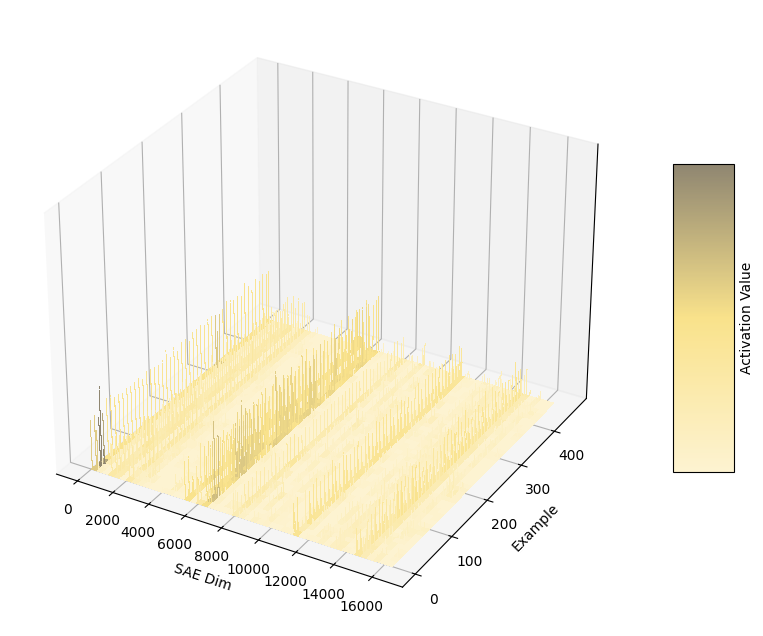

In [5]:
get_3d_plot(gemma_humaneval_results, 17)

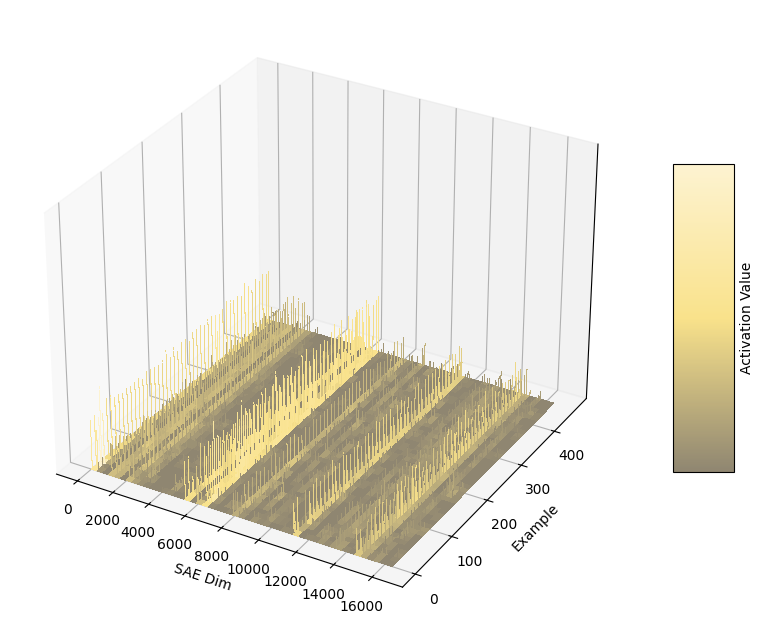

In [8]:
get_3d_plot(gemma_humaneval_results, 17)

In [ ]:

get_3d_plot(gemma_humaneval_results, 17, False)

In [ ]:
results = gemma_defects_results
# Create the figure and subplots (each will be 3D)
fig = plt.figure(figsize=(30, 20))
axes = []

for i in range(48):
    ax = fig.add_subplot(4*2, 6, i + 1, projection='3d')
    axes.append(ax)

legend_handles = []
legend_labels = []

safe_column_idx = 0
surf = None  # Initialize surf outside the loop


    
columns = 0
for result_idx, result in tqdm(enumerate(results),total=len(results)):
    for idx in range(2):

        if idx%2==0:
            axe_idx =  (result_idx % 6 ) + (columns*12)
            column = "sil_safe"
            cmap = 'viridis' 
        else:
            axe_idx = (result_idx % 6 ) + (columns*12) + 6
            column = "sil_vuln"
            cmap = 'Reds'

        
        if (axe_idx+1) % 12 == 0 and axe_idx != 0:
            columns += 1
        ax_safe = axes[axe_idx]

        # Define the ranges
        X = np.arange(0, 16384)
        Y = np.arange(0, 467)

        # Create the meshgrid
        X_mesh, Y_mesh = np.meshgrid(X, Y, indexing='ij')
        

        # Fill Z with your data
        Z = np.zeros((16384, 467))
        for sae_dim in range(16384):
            for example in range(467):
                Z[sae_dim, example] = result[column][example][sae_dim]

        # Plot the surface
        surf = ax_safe.plot_surface(X_mesh, Y_mesh, Z, cmap=cmap, linewidth=0, antialiased=False)

        # Labels (optional: make them smaller for clarity)
        ax_safe.set_xlabel('SAE Dim', fontsize=8)
        ax_safe.set_ylabel('Example', fontsize=8)
        ax_safe.set_zlabel('Activation', fontsize=8)
        ax_safe.set_title(f'Layer {result_idx}', fontsize=10)

        # set z axis limits
        ax.set_zlim(0, 200)
        # remove the grid for z
        # ax.set_zticks([])
        # ax.set_zticklabels([])
    


# Adjust layout
fig.suptitle("Gemma2 2B Activation by Layer (Safe vs Vulnerable) on Defects4j", fontsize=26, weight='bold', y=1.02)

# Adjust layout to bring subplots closer together
plt.subplots_adjust(
    left=0.03, right=0.97, top=0.93, bottom=0.05,
    wspace=0.08, hspace=0.2  # Reduced spacing between plots for tighter layout
)

# Add a global color bar
fig.colorbar(surf, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)


plt.show()


In [ ]:
results = gemma_gbug_results
# Create the figure and subplots (each will be 3D)
fig = plt.figure(figsize=(30, 20))
axes = []

for i in range(48):
    ax = fig.add_subplot(4*2, 6, i + 1, projection='3d')
    axes.append(ax)

legend_handles = []
legend_labels = []

safe_column_idx = 0
surf = None  # Initialize surf outside the loop


    
columns = 0
for result_idx, result in tqdm(enumerate(results),total=len(results)):
    for idx in range(2):

        if idx%2==0:
            axe_idx =  (result_idx % 6 ) + (columns*12)
            column = "sil_safe"
            cmap = 'viridis' 
        else:
            axe_idx = (result_idx % 6 ) + (columns*12) + 6
            column = "sil_vuln"
            cmap = 'Reds'

        
        if (axe_idx+1) % 12 == 0 and axe_idx != 0:
            columns += 1
        ax_safe = axes[axe_idx]

        # Define the ranges
        X = np.arange(0, 16384)
        Y = np.arange(0, 467)

        # Create the meshgrid
        X_mesh, Y_mesh = np.meshgrid(X, Y, indexing='ij')
        

        # Fill Z with your data
        Z = np.zeros((16384, 467))
        for sae_dim in range(16384):
            for example in range(467):
                Z[sae_dim, example] = result[column][example][sae_dim]

        # Plot the surface
        surf = ax_safe.plot_surface(X_mesh, Y_mesh, Z, cmap=cmap, linewidth=0, antialiased=False)

        # Labels (optional: make them smaller for clarity)
        ax_safe.set_xlabel('SAE Dim', fontsize=8)
        ax_safe.set_ylabel('Example', fontsize=8)
        ax_safe.set_zlabel('Activation', fontsize=8)
        ax_safe.set_title(f'Layer {result_idx}', fontsize=10)

    


# Adjust layout
fig.suptitle("Gemma2 2B Activation by Layer (Safe vs Vulnerable) on Github Bug Java", fontsize=26, weight='bold', y=1.02)

# Adjust layout to bring subplots closer together
plt.subplots_adjust(
    left=0.03, right=0.97, top=0.93, bottom=0.05,
    wspace=0.08, hspace=0.2  # Reduced spacing between plots for tighter layout
)

# Add a global color bar
fig.colorbar(surf, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)


plt.show()


In [ ]:
results = gemma_gbug_results
# Create the figure and subplots (each will be 3D)
fig = plt.figure(figsize=(30, 20))
axes = []

for i in range(48):
    ax = fig.add_subplot(4*2, 6, i + 1, projection='3d')
    axes.append(ax)

legend_handles = []
legend_labels = []

safe_column_idx = 0
surf = None  # Initialize surf outside the loop


    
columns = 0
for result_idx, result in tqdm(enumerate(results),total=len(results)):
    for idx in range(2):

        if idx%2==0:
            axe_idx =  (result_idx % 6 ) + (columns*12)
            column = "sil_safe"
            cmap = 'viridis' 
        else:
            axe_idx = (result_idx % 6 ) + (columns*12) + 6
            column = "sil_vuln"
            cmap = 'Reds'

        
        if (axe_idx+1) % 12 == 0 and axe_idx != 0:
            columns += 1
        ax_safe = axes[axe_idx]

        # Define the ranges
        X = np.arange(0, 16384)
        Y = np.arange(0, 467)

        # Create the meshgrid
        X_mesh, Y_mesh = np.meshgrid(X, Y, indexing='ij')
        

        # Fill Z with your data
        Z = np.zeros((16384, 467))
        for sae_dim in range(16384):
            for example in range(467):
                Z[sae_dim, example] = result[column][example][sae_dim]

        # Plot the surface
        surf = ax_safe.plot_surface(X_mesh, Y_mesh, Z, cmap=cmap, linewidth=0, antialiased=False)

        # Labels (optional: make them smaller for clarity)
        ax_safe.set_xlabel('SAE Dim', fontsize=8)
        ax_safe.set_ylabel('Example', fontsize=8)
        ax_safe.set_zlabel('Activation', fontsize=8)
        ax_safe.set_title(f'Layer {result_idx}', fontsize=10)

    


# Adjust layout
fig.suptitle("Gemma2 2B Activation by Layer (Safe vs Vulnerable) on Human Eval Java", fontsize=26, weight='bold', y=1.02)

# Adjust layout to bring subplots closer together
plt.subplots_adjust(
    left=0.03, right=0.97, top=0.93, bottom=0.05,
    wspace=0.08, hspace=0.2  # Reduced spacing between plots for tighter layout
)

# Add a global color bar
fig.colorbar(surf, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)


plt.show()
